# 1. Some understandings about our credit card fraud data

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation, so we do not transform the faetures that are V1,...,V28. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
!pip install pyngrok

In [2]:
!pip install streamlit

## 1.1 Spliting train data and test data

In [3]:
# import libararys
import pandas as pd
from sklearn.preprocessing import RobustScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from pyngrok import ngrok
import streamlit as st

In [4]:
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# split train and test as the data includes the data of nearly two days
df_train = df.iloc[:(len(df)//2)]
df_test = df.iloc[(len(df)//2):]
# then we analyze the train data and use it for our training  , finally, we use test data to evalute our models
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
#count the fraud transaction in train and test data
print("Fraud count in df_train:", df_train['Class'].sum())
print("Fraud count in df_test :", df_test['Class'].sum())

Fraud count in df_train: 269
Fraud count in df_test : 223


In [8]:
df_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,...,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000,142403.000000
mean,52402.922424,-0.249369,0.020786,0.673759,0.137167,-0.282933,0.078243,-0.118221,0.064969,-0.089152,...,-0.039749,-0.117939,-0.033259,0.011263,0.130894,0.021567,0.000700,0.002263,90.687055,0.001889
std,21104.546393,1.814061,1.610309,1.266018,1.322356,1.305022,1.282544,1.165530,1.233597,1.090284,...,0.721186,0.634611,0.589846,0.595726,0.437316,0.492375,0.388678,0.306209,246.459558,0.043422
min,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-22.565679,-11.710896,0.000000,0.000000
25%,38190.500000,-1.021159,-0.560007,0.171462,-0.718089,-0.903787,-0.662023,-0.604821,-0.130534,-0.713160,...,-0.225799,-0.547094,-0.171829,-0.325901,-0.135876,-0.327178,-0.060092,-0.004181,5.990000,0.000000
50%,54201.000000,-0.271756,0.106016,0.750692,0.164312,-0.315374,-0.177339,-0.064749,0.081070,-0.153461,...,-0.059512,-0.094206,-0.045135,0.068268,0.167488,-0.066460,0.012140,0.023615,23.560000,0.000000
75%,70131.000000,1.158507,0.777726,1.363765,0.991350,0.236510,0.463246,0.409101,0.375334,0.487212,...,0.113082,0.300538,0.083055,0.408259,0.420209,0.284527,0.087769,0.077020,80.100000,0.000000
max,84691.000000,1.960497,18.902453,9.382558,16.715537,34.801666,22.529298,36.677268,20.007208,15.594995,...,27.202839,10.503090,19.002942,4.022866,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


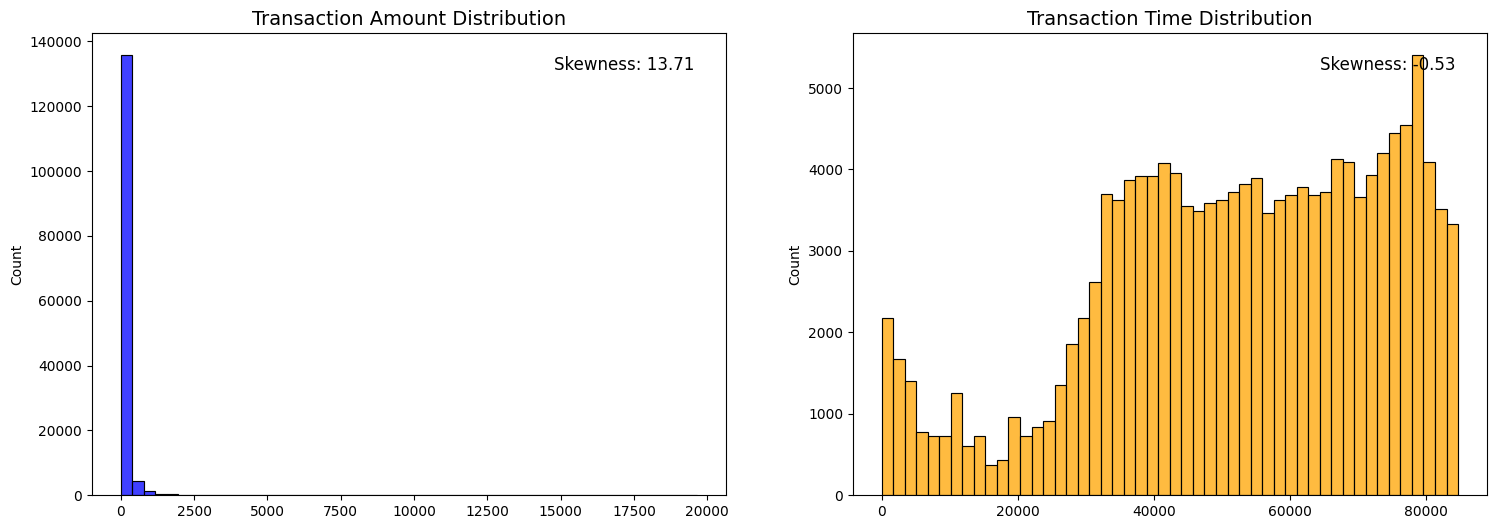

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

amount_val = df_train['Amount'].values
time_val = df_train['Time'].values

amount_skew = skew(amount_val)
time_skew = skew(time_val)

sns.histplot(amount_val, bins=50, ax=ax[0], color='blue')
ax[0].set_title('Transaction Amount Distribution', fontsize=14)
ax[0].text(0.95, 0.95, f'Skewness: {amount_skew:.2f}', transform=ax[0].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

sns.histplot(time_val, bins=50, ax=ax[1], color='orange')
ax[1].set_title('Transaction Time Distribution', fontsize=14)
ax[1].text(0.95, 0.95, f'Skewness: {time_skew:.2f}', transform=ax[1].transAxes,
           fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.show()

1) Transaction Amount Distribution (Skewness = 13.71)

Extremely right-skewed (long-tail).

Most transactions are very small; a few very large transactions exist.

This pattern is typical in financial data.

Fraud often happens at the extremes (very small “test” transactions or very large “cash-out” amounts).

Strong skew means the raw Amount is not suitable for modeling

2) Transaction Time Distribution (Skewness = –0.53)

Distribution is almost uniform, slight left skew but not meaningful.

“Time” here is only seconds since the first transaction, so it carries no behavioral meaning.

Must transform Time into hour-of-day features because fraud behavior depends on time periods (e.g., late-night activity).

In [10]:
print('no frauds', round(df_train['Class'].value_counts()[0]/len(df_train)*100,2) , '% of the dataset')
print('fraud', round(df_train['Class'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

no frauds 99.81 % of the dataset
fraud 0.19 % of the dataset


highly imbalenced

In [11]:
df_train.isnull().sum().max()

0

In [12]:
df_test.isnull().sum().max()

0

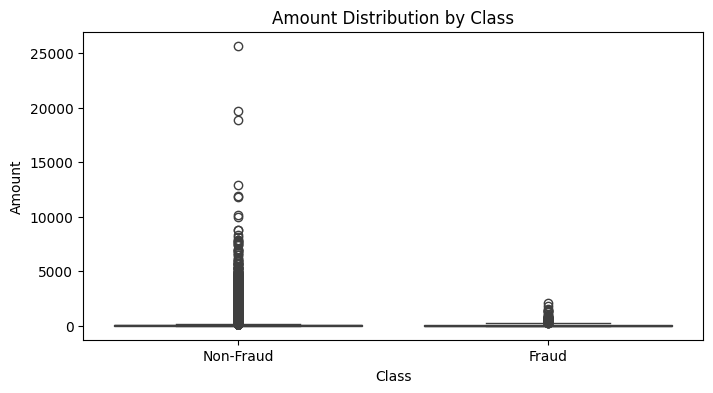

In [13]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.boxplot(x=df["Class"], y=df["Amount"])
plt.xticks([0,1], ["Non-Fraud","Fraud"])
plt.title("Amount Distribution by Class")
plt.show()


Fraudsters in this dataset do not use unusually large or standout transaction amounts. Instead, they keep amounts small and inconspicuous, making the fraud harder to detect.

# 2. Scaler

As V1->V28 are PCA features , them were scaled . Because of that , column "Amount" should be scaled

RobustScaler is used to scale the 'Amount' feature because it is resilient to outliers. Unlike StandardScaler, which uses mean and variance, RobustScaler scales data using the median and interquartile range (IQR), ensuring that extreme transaction values do not distort the feature distribution.

In [14]:
rob_scaler = RobustScaler()
df_train['scaled_amount'] = rob_scaler.fit_transform(df_train['Amount'].values.reshape(-1, 1))
df_train.drop(['Amount'], axis=1, inplace=True)
print(df_train.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

/tmp/ipython-input-647662420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['scaled_amount'] = rob_scaler.fit_transform(df_train['Amount'].values.reshape(-1, 1))
/tmp/ipython-input-647662420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['Amount'], axis=1, inplace=True)


In [15]:
#we transform the distrubution of train into test
df_test['scaled_amount'] = rob_scaler.transform(df_test['Amount'].values.reshape(-1,1))
df_test.drop(['Amount'], axis=1, inplace=True)
print(df_test.head())

           Time        V1        V2        V3        V4        V5        V6  \
142403  84692.0  1.125592 -0.147999  1.151008  1.158851 -0.823914  0.298829   
142404  84693.0 -0.439952  0.683758  1.225814  0.639113  0.716765  0.089295   
142405  84694.0 -4.868108  1.264420 -5.167885  3.193648 -3.045621 -2.096166   
142406  84695.0  1.013114 -0.334412  1.305208  0.837406 -1.126833 -0.064321   
142407  84695.0  0.969231 -0.233554  0.238473  0.145793 -0.545741 -0.970680   

              V7        V8        V9  ...       V21       V22       V23  \
142403 -0.708732  0.294683  0.750838  ... -0.037453  0.024388 -0.052720   
142404  0.657718  0.034213 -0.472679  ...  0.127443  0.588590 -0.145728   
142405 -6.445610  2.422536 -3.214055  ...  1.269205  0.057657  0.629307   
142406 -0.594753  0.147737  0.536360  ...  0.017079  0.112210 -0.016084   
142407  0.347393 -0.209522 -0.342571  ... -0.362820 -1.417272  0.162136   

             V24       V25       V26       V27       V28  Class  scaled_am

/tmp/ipython-input-972549016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['scaled_amount'] = rob_scaler.transform(df_test['Amount'].values.reshape(-1,1))
/tmp/ipython-input-972549016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['Amount'], axis=1, inplace=True)


In [16]:
#saving the scaler
joblib.dump(rob_scaler, "robust_scaler.pkl")

['robust_scaler.pkl']

# 3. EDA

## 3.1 Time features

We will exchange the seconds time column to hours in order to visualize easily

In [17]:
df_train["hour_of_day"] = (df_train["Time"] / 3600) % 24
df_train["hour_of_day"]

/tmp/ipython-input-1731210150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["hour_of_day"] = (df_train["Time"] / 3600) % 24


,hour_of_day
0,0.000000
1,0.000000
2,0.000278
3,0.000278
4,0.000556
...,...
142398,23.524722
142399,23.525000
142400,23.525000
142401,23.525278


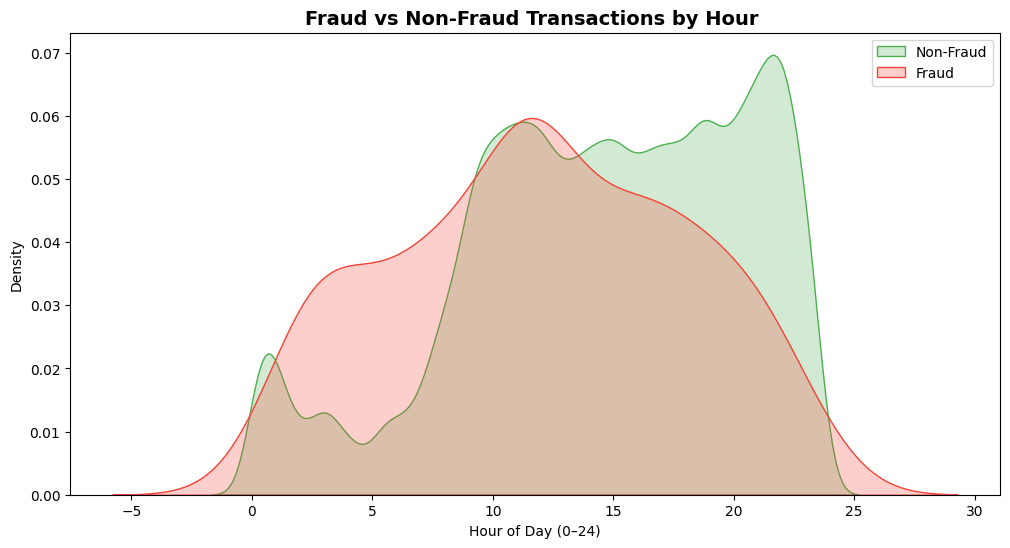

In [18]:
#visulizing
plt.figure(figsize=(12,6))
sns.kdeplot(df_train[df_train['Class']==0]["hour_of_day"], label='Non-Fraud', fill=True, color='#4CAF50')
sns.kdeplot(df_train[df_train['Class']==1]["hour_of_day"], label='Fraud', fill=True, color='#F44336')
plt.title('Fraud vs Non-Fraud Transactions by Hour ', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day (0–24)')
plt.ylabel('Density')
plt.legend()
plt.show()

Between 1 AM and 5 AM, there is a clear increase in fraudulent transactions (red area), while non-fraudulent transactions (green area) noticeably decrease. This inverse pattern indicates that fraudsters may take advantage of off-peak hours, when normal user activity is minimal and system monitoring or manual reviews are less active.

From 8 AM to 8 PM, the level of fraudulent transactions remains relatively high, following a similar trend to non-fraudulent transactions.This indicates that fraudulent activities are not limited to off-peak hours — fraudsters also operate during normal business hours, possibly blending in with regular user behavior to avoid detection.

In [19]:
df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour_of_day'] / 24)
df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour_of_day'] / 24)

/tmp/ipython-input-2401169001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour_of_day'] / 24)
/tmp/ipython-input-2401169001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour_of_day'] / 24)


Why We Use hour_sin and hour_cos Instead of Raw Hour Values

The original Time feature represents elapsed seconds since the first recorded transaction. To extract meaningful temporal patterns (e.g., fraud tends to occur more frequently at night), we convert this into hour-of-day. However, hour-of-day is a cyclic variable:

After 23:00 comes 00:00

23h and 0h are very close in reality

But in numeric form: 23 and 0 appear far apart

This discontinuity causes issues for correlation, distance-based models, and neural network optimization.

Problem with Using Raw Hour Values (0–23)

Using a single column like:

0, 1, 2, ..., 23

introduces false distances:

Distance between 23 and 0 = 23 (but in reality, they are only 1 hour apart)

Distance between 10 and 11 = 1 (correct)

Distance between 22 and 2 = 20 (but they are only 4 hours apart on the clock)

Therefore:

Pearson correlation becomes unreliable

Linear/logistic regression misinterprets relationships

Distance-based models (KNN, SVM) behave incorrectly

Tree models require unnecessary splits

Neural networks need more capacity to approximate the cyclic pattern

Conclusion: raw hour encoding does not reflect the true structure of time.

## 3.2 EDA with the help of correlation

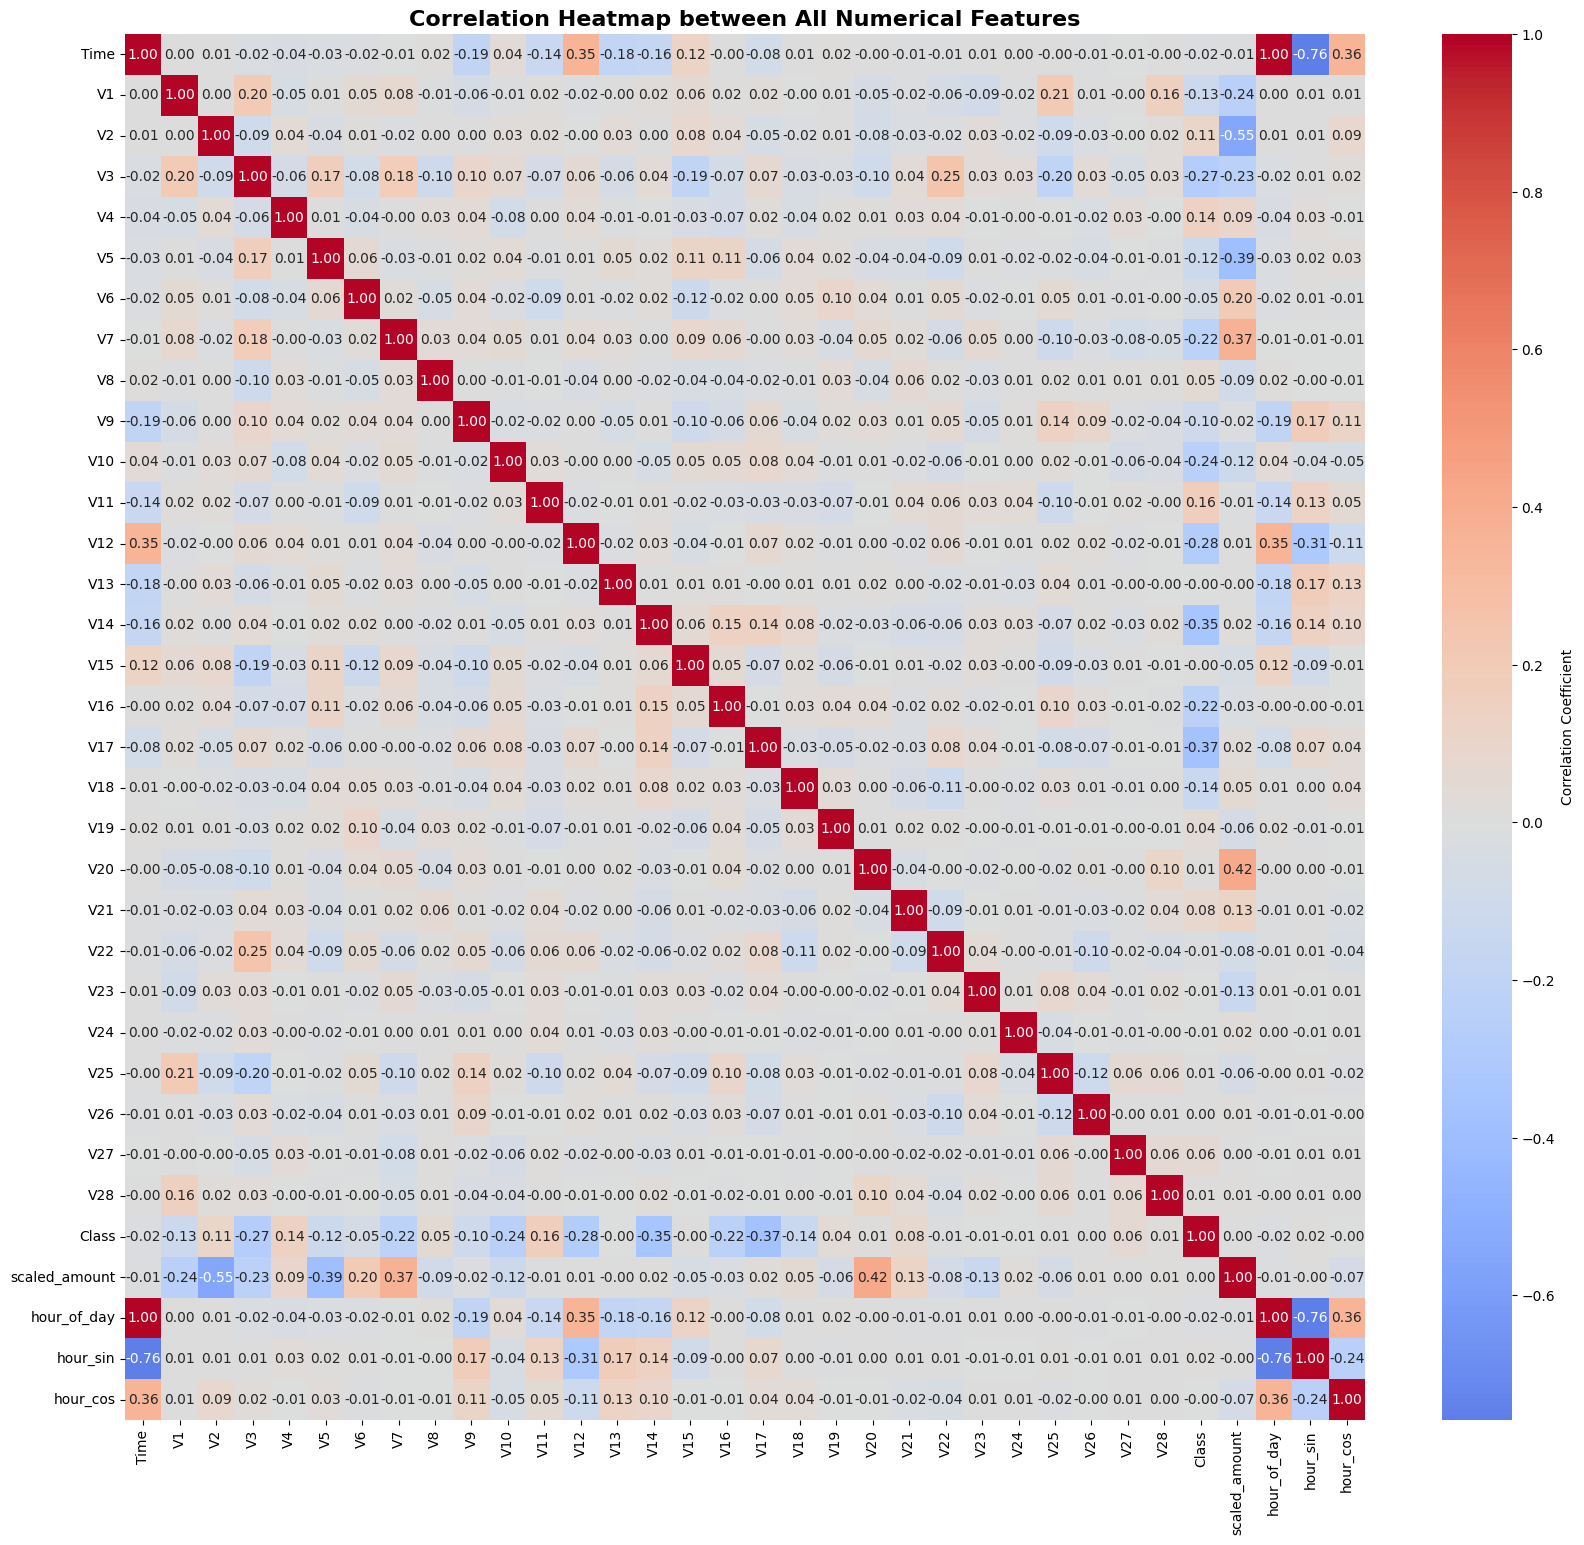

In [20]:
numeric_df = df_train.select_dtypes(include=["number"])
corr_matrix = numeric_df.corr()


plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Heatmap between All Numerical Features", fontsize=16, fontweight='bold')
plt.show()

The PCA-generated features (V1–V28) show correlations close to zero, which is expected because PCA produces components that are nearly uncorrelated. This confirms that multicollinearity is minimal in the dataset.

The feature hour-sin is more corrlated to hour_of_day, so we remove the hour-cos feature in training

V3, V7, V10, V12, V14, V16, V17 are the most correlated features. Because of that, I will implement the isolation forest method so as to serving the anomaly detection job

In [21]:
features = ["V3","V7","V10","V12","V14","V16","V17"]

iso = IsolationForest(n_estimators=100, max_samples='auto',
                      contamination=0.01, random_state=42)

iso.fit(df_train[features])

df_train['risk_score_if'] = -iso.decision_function(df_train[features])# higher value reflects the fraud chances
df_train['risk_score_if'].head()

/tmp/ipython-input-723133135.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['risk_score_if'] = -iso.decision_function(df_train[features])# higher value reflects the fraud chances


,risk_score_if
0,-0.240843
1,-0.273993
2,-0.144078
3,-0.253096
4,-0.239045


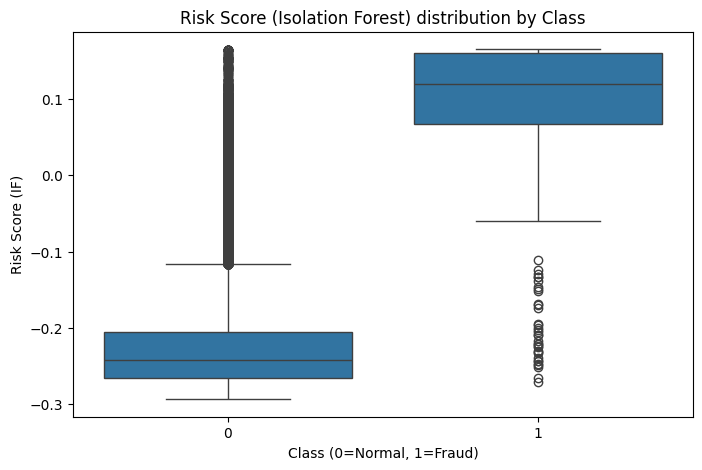

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='risk_score_if', data=df_train)
plt.title("Risk Score (Isolation Forest) distribution by Class")
plt.xlabel("Class (0=Normal, 1=Fraud)")
plt.ylabel("Risk Score (IF)")
plt.show()

Fraud cases (Class = 1) have much higher risk scores (mostly around 0.08–0.16).
→ Isolation Forest considers them significantly more anomalous.

Normal transactions (Class = 0) have much lower risk scores (around –0.20 to –0.15).
→ IF identifies them as normal / non-isolated.

There is some overlap, but the separation between the medians is very large.
→ This means risk_score_if is a highly informative new feature.

In [23]:
# saving the parameters of IF
joblib.dump(iso, "isolation_forest.pkl")

['isolation_forest.pkl']

In [24]:
# we should create the function in order to serving the new test data
def EDA(df):
  df["hour_of_day"] = (df["Time"] / 3600) % 24
  if_features = ["V3","V7","V10","V12","V14","V16","V17"]
  df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
  df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
  df["risk_score_if"] = -iso.decision_function(df[if_features])
  return df
df_test = EDA(df_test)

/tmp/ipython-input-2150611167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour_of_day"] = (df["Time"] / 3600) % 24
/tmp/ipython-input-2150611167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
/tmp/ipython-input-2150611167.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

# Training and Testing

In [25]:
df_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaled_amount', 'hour_of_day', 'hour_sin', 'hour_cos',
       'risk_score_if'],
      dtype='object')

In [26]:
df_test.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaled_amount', 'hour_of_day', 'hour_sin', 'hour_cos',
       'risk_score_if'],
      dtype='object')

In [27]:
columns_drop = ["hour_of_day","hour_cos","Time"]
df_train = df_train.drop(columns=columns_drop)
df_test = df_test.drop(columns=columns_drop)
df_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,scaled_amount,hour_sin,risk_score_if
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.700985,0.000000,-0.240843
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.281608,0.000000,-0.273993
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.791526,0.000073,-0.144078
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.348536,0.000073,-0.253096
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.626501,0.000145,-0.239045


## 4.1 Logstic regression

In [28]:
X_train = df_train.drop(columns=['Class'])
y_train = df_train['Class']

X_test = df_test[X_train.columns]


lr = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
y_test_prob = lr.predict_proba(X_test)[:,1]

if 'Class' in df_test.columns:
    y_test_true = df_test['Class']
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_true, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test_true, y_test_pred, digits=4))

Confusion Matrix:
[[137459   4722]
 [    27    196]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9668    0.9830    142181
           1     0.0399    0.8789    0.0762       223

    accuracy                         0.9667    142404
   macro avg     0.5198    0.9229    0.5296    142404
weighted avg     0.9983    0.9667    0.9816    142404



High recall for fraud (87.89%) → the model successfully detects most fraudulent transactions.

In [29]:
   print("\nTest ROC AUC Score:", roc_auc_score(y_test_true, y_test_prob))


Test ROC AUC Score: 0.9462731975912848


In [30]:
# Save model
joblib.dump(lr, "logistic_fraud_model.pkl")

['logistic_fraud_model.pkl']

## 4.2 XG-boost

In [31]:
features = df_train.drop(columns=['Class']).columns.tolist()
X = df_train[features]
y = df_train['Class']

X_test = df_test[features]


X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': (len(y_tr)-sum(y_tr))/sum(y_tr),  # balance imbalance
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=50
)

y_val_prob = bst.predict(dval)
y_val_pred = (y_val_prob > 0.5).astype(int)

print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))
print("\nValidation ROC AUC Score:", roc_auc_score(y_val, y_val_prob))

y_test_prob = bst.predict(dtest)
y_test_pred = (y_test_prob > 0.5).astype(int)

if 'Class' in df_test.columns:
    y_test_true = df_test['Class']
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test_true, y_test_pred))
    print("\nTest Classification Report:")
    print(classification_report(y_test_true, y_test_pred, digits=4))
    print("\nTest ROC AUC Score:", roc_auc_score(y_test_true, y_test_prob))

[0]	train-auc:0.98921	eval-auc:0.96033
[20]	train-auc:0.99982	eval-auc:0.95873
Validation Confusion Matrix:
[[28367    60]
 [    8    46]]

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9979    0.9988     28427
           1     0.4340    0.8519    0.5750        54

    accuracy                         0.9976     28481
   macro avg     0.7168    0.9249    0.7869     28481
weighted avg     0.9986    0.9976    0.9980     28481


Validation ROC AUC Score: 0.9587263152271771

Test Confusion Matrix:
[[141816    365]
 [    48    175]]

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9974    0.9985    142181
           1     0.3241    0.7848    0.4587       223

    accuracy                         0.9971    142404
   macro avg     0.6619    0.8911    0.7286    142404
weighted avg     0.9986    0.9971    0.9977    142404


Test ROC AUC Score: 0.963689070865680

In [32]:
# save model
bst.save_model("xgb_fraud_model.json")

# Demo UI

In [33]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

@st.cache_resource
def load_artifacts():
    bst = xgb.Booster()
    bst.load_model("/content/xgb_fraud_model.json")

    rob_scaler = joblib.load("/content/robust_scaler.pkl")
    iso = joblib.load("/content/isolation_forest.pkl")

    return bst, rob_scaler, iso

bst, rob_scaler, iso = load_artifacts()

def preprocess_raw_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()
    df = df.drop_duplicates().reset_index(drop=True)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].fillna(0)
    df["scaled_amount"] = rob_scaler.transform(df[["Amount"]])

    if "Time" not in df.columns:
        raise ValueError("Input CSV must contain column 'Time'.")
    df["hour_of_day"] = (df["Time"] / 3600) % 24
    df["hour_sin"] = np.sin(2 * np.pi * df["hour_of_day"] / 24)

    if "Amount" not in df.columns:
        raise ValueError("Input CSV must contain column 'Amount'.")

    if_features = ["V3", "V7", "V10", "V12", "V14", "V16", "V17"]
    missing_if = [c for c in if_features if c not in df.columns]
    if missing_if:
        raise ValueError(f"Input CSV is missing IF features: {missing_if}")

    df["risk_score_if"] = -iso.decision_function(df[if_features])
    df = df.drop(columns =['Amount','hour_of_day','Time'])
    return df

st.title("Credit Card Fraud Detection – XGBoost Demo (Raw CSV)")

st.write(
    """
    - Upload **file CSV gốc** giống Kaggle (có các cột: Time, V1..V28, Amount, [Class]).
    - App sẽ tự:
        1. Làm feature engineering (hour_sin, scaled_amount, risk_score_if)
        2. Dự đoán xác suất fraud bằng XGBoost
    """
)

uploaded_file = st.file_uploader("Upload raw CSV file", type=["csv"])

threshold = st.slider(
    "Decision threshold cho fraud (default = 0.5)",
    min_value=0.0,
    max_value=1.0,
    value=0.5,
    step=0.01
)

if uploaded_file is not None:
    try:
        df_raw = pd.read_csv(uploaded_file)
    except Exception as e:
        st.error(f"Lỗi khi đọc CSV: {e}")
    else:
        st.subheader("Preview raw data")
        st.dataframe(df_raw.head())

        try:
            df_proc = preprocess_raw_df(df_raw)
        except Exception as e:
            st.error(f"Lỗi khi preprocess dữ liệu: {e}")
        else:
            st.subheader("Preview processed data (after feature engineering)")
            st.dataframe(df_proc.head())

            feature_cols = [c for c in df_proc.columns if c != "Class"]
            X_new = df_proc[feature_cols]

            dnew = xgb.DMatrix(X_new)
            y_prob = bst.predict(dnew)
            y_pred = (y_prob >= threshold).astype(int)

            df_result = df_proc.copy()
            df_result["fraud_prob"] = y_prob
            df_result["fraud_pred"] = y_pred

            st.subheader("Prediction results")
            st.write("`fraud_pred = 1` = giao dịch bị flag nghi ngờ fraud.")
            st.dataframe(df_result.head(20))

            n_total = len(df_result)
            n_flag  = int(df_result["fraud_pred"].sum())
            st.write(f"🔎 Total transactions: {n_total}")
            st.write(f"🚨 Flagged as fraud: {n_flag}")

            if "Class" in df_result.columns:
                from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

                y_true = df_result["Class"]
                cm = confusion_matrix(y_true, y_pred)
                st.subheader("Confusion Matrix (if ground truth is present)")
                st.text(cm)

                st.text("\nClassification Report:")
                st.text(classification_report(y_true, y_pred, digits=4))

                try:
                    auc = roc_auc_score(y_true, y_prob)
                    st.text(f"\nROC AUC: {auc:.4f}")
                except Exception:
                    pass

            st.subheader("Top 20 most suspicious transactions (highest fraud_prob)")
            df_top = df_result.sort_values("fraud_prob", ascending=False).head(20)
            st.dataframe(df_top)

Overwriting app.py


In [34]:
ngrok.set_auth_token("377LsGHmjfkEDEYbsTu5opUVwAJ_68eV2oWtcsnZLM2ZfpYYp")

In [35]:
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://cachectical-amorously-erlinda.ngrok-free.dev" -> "http://localhost:8501"


In [36]:
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0





  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
  Stopping...
  Stopping...
